In [2]:
# !pip install geopandas folium matplotlib seaborn scipy
# !pip install esda
# !pip install splot
# # for google colab, had to reinstall some pacakges.

In [3]:
import pandas as pd
import geopandas as gpd
import numpy as np
import datetime as dt
import scipy

from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist
from scipy import stats

# visualization
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import seaborn as sns
import folium
from folium.plugins import HeatMap
from folium import Marker
from folium.plugins import MarkerCluster
import plotly.express as px
import plotly.io as pio

# spatial statistics
from esda.moran import Moran
from esda.getisord import G_Local
from libpysal.weights import Queen, Rook

# system and utility
import warnings
import os
import io
from IPython.display import IFrame
from google.colab import files

from libpysal.weights import Queen, Rook
from esda.moran import Moran
import matplotlib.pyplot as plt
from splot.esda import moran_scatterplot

# suppress warnings
warnings.filterwarnings('ignore')

# inline
%matplotlib inline

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# data source:
file_path1 = '/content/drive/My Drive/X999/bbl_evictions_merged.csv'
file_path3 = '/content/drive/My Drive/X999/bbl_cleaned.csv'
# file_path2 = '/content/drive/My Drive/X999/evictions_pre_post_covid.csv'

In [306]:
# evictions = pd.read_csv(file_path2)
bbl_cleaned = pd.read_csv(file_path3)

In [9]:
# list(bbl_cleaned.columns),
bbl_cleaned.shape
# so 753110 res buildings
# will use this number to calculate the average number of evictions per building, but not only the builingds that
# have the evictions, but all the res buildings

(753110, 110)

In [8]:
# evictions.eviction_count.sum()

In [7]:
bbl_evictions_merged_raw = pd.read_csv(file_path1)

In [8]:
bbl_evictions_merged = bbl_evictions_merged_raw.copy()

In [9]:
display(bbl_evictions_merged.head()), bbl_evictions_merged.shape

,court_index_number,docket_number,eviction_address,eviction_apartment_number,executed_date,borough,eviction_postcode,ejectment,eviction/legal_possession,latitude,...,building_category,is_condo,floor_category,rent_era,architectural_style,economic_period,residential_units_category,is_llc,building_size_category,size_quartile
0,34859/16,53416,3476 SEYMOUR AVENUE,3-B,2017-01-03,BRONX,10469,Not an Ejectment,Possession,40.877620,...,walk-up,False,mid-rise,"Pre-1947, pre-rent-control","1931–1950, Manhattan Modern","1930-1945, great depression and WWII",100+ units,True,mega,Q4 (largest 25%)
1,B57808/16,74242,1426 BRYANT AVENUE,10 AKA 2ND FL UNIT,2017-01-03,BRONX,10459,Not an Ejectment,Possession,40.830691,...,two-family,False,low-rise,"1994–Present, vacancy decontrol","1981–2000, Post-Modernism","1991–2008, modern economic growth",2-unit,False,small,Q3 (50-75%)
2,N069212/14,355977,1309 5TH AVENUE,24H,2017-01-03,MANHATTAN,10029,Not an Ejectment,Possession,40.797309,...,elevator,False,high-rise,"1970–1993, deregularization","1951–1980, the International Style, Alternativ...","1946–1975, pst war economic boom",100+ units,False,mega,Q4 (largest 25%)
3,K065455/16,367441,458 EAST 51 STREET,6A,2017-01-03,BROOKLYN,11203,Not an Ejectment,Possession,40.650624,...,elevator,False,mid-rise,"Pre-1947, pre-rent-control","1931–1950, Manhattan Modern","1930-1945, great depression and WWII",21-100 units,True,very large,Q4 (largest 25%)
4,33992/16,458984,580 EAST 168TH STREE T,*,2017-01-03,BRONX,10456,Not an Ejectment,Possession,40.830494,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(None, (74082, 39))

In [10]:
type(bbl_evictions_merged.executed_date[0]), bbl_evictions_merged.executed_date[0]
bbl_evictions_merged['executed_date'] = pd.to_datetime(bbl_evictions_merged['executed_date'], format='%Y-%m-%d')
bbl_evictions_merged['executed_date'].dt.year.unique() # 5 years

array([2017, 2018, 2019, 2023, 2024], dtype=int32)

In [11]:
building_characteristics = [
    'yearbuilt', 'bldgclass', 'numfloors', 'unitsres', 'ownername', 'bldgarea',
    'building_type', 'building_category', 'is_condo', 'floor_category',
    'rent_era', 'architectural_style', 'economic_period',
    'residential_units_category', 'is_llc', 'building_size_category',
    'size_quartile', 'yearbuilt', 'numfloors', 'unitsres'
]

In [12]:
nan_counts = bbl_evictions_merged[building_characteristics].isna().sum()
nan_percentages = (nan_counts / len(bbl_evictions_merged) * 100).round(3)
# percentage:.3f%

In [13]:
nan_counts, nan_percentages

(yearbuilt                     3770
 bldgclass                     3770
 numfloors                     3770
 unitsres                      3770
 ownername                     3770
 bldgarea                      3770
 building_type                 3770
 building_category             3770
 is_condo                      3770
 floor_category                3770
 rent_era                      3770
 architectural_style           3770
 economic_period               3770
 residential_units_category    3770
 is_llc                        3770
 building_size_category        3770
 size_quartile                 3770
 yearbuilt                     3770
 numfloors                     3770
 unitsres                      3770
 dtype: int64,
 yearbuilt                     5.089
 bldgclass                     5.089
 numfloors                     5.089
 unitsres                      5.089
 ownername                     5.089
 bldgarea                      5.089
 building_type                 5.089
 build

In [14]:
bbl_evictions_merged.shape

(74082, 39)

In [15]:
df = bbl_evictions_merged.copy()

In [16]:
df = bbl_evictions_merged.dropna(subset=['average_year_eviction_count'])

In [17]:
df.shape

(74082, 39)

In [18]:
df_clean = df.dropna(subset=building_characteristics)

In [19]:
df_clean.shape, 74082 - 70312
# good

((70312, 39), 3770)

In [20]:
df_clean['eviction_rate_per_unit'] = df_clean['average_year_eviction_count'] / df_clean['unitsres']
df_clean['eviction_rate_per_unit'] = df_clean['eviction_rate_per_unit'].replace([np.inf, -np.inf], np.nan)
# second line handles potential division by zero errors

In [21]:
display(df_clean.head())

,court_index_number,docket_number,eviction_address,eviction_apartment_number,executed_date,borough,eviction_postcode,ejectment,eviction/legal_possession,latitude,...,is_condo,floor_category,rent_era,architectural_style,economic_period,residential_units_category,is_llc,building_size_category,size_quartile,eviction_rate_per_unit
0,34859/16,53416,3476 SEYMOUR AVENUE,3-B,2017-01-03,BRONX,10469,Not an Ejectment,Possession,40.877620,...,False,mid-rise,"Pre-1947, pre-rent-control","1931–1950, Manhattan Modern","1930-1945, great depression and WWII",100+ units,True,mega,Q4 (largest 25%),0.016456
1,B57808/16,74242,1426 BRYANT AVENUE,10 AKA 2ND FL UNIT,2017-01-03,BRONX,10459,Not an Ejectment,Possession,40.830691,...,False,low-rise,"1994–Present, vacancy decontrol","1981–2000, Post-Modernism","1991–2008, modern economic growth",2-unit,False,small,Q3 (50-75%),0.500000
2,N069212/14,355977,1309 5TH AVENUE,24H,2017-01-03,MANHATTAN,10029,Not an Ejectment,Possession,40.797309,...,False,high-rise,"1970–1993, deregularization","1951–1980, the International Style, Alternativ...","1946–1975, pst war economic boom",100+ units,False,mega,Q4 (largest 25%),0.006667
3,K065455/16,367441,458 EAST 51 STREET,6A,2017-01-03,BROOKLYN,11203,Not an Ejectment,Possession,40.650624,...,False,mid-rise,"Pre-1947, pre-rent-control","1931–1950, Manhattan Modern","1930-1945, great depression and WWII",21-100 units,True,very large,Q4 (largest 25%),0.050314
6,50104/16,318266,598 E 183 ST AKA 2239 ADAMS PL,26,2017-01-03,BRONX,10457,Not an Ejectment,Possession,40.853070,...,False,mid-rise,"Pre-1947, pre-rent-control","1900–1920, Beaux-Arts","Pre-1929, pre-great depression",21-100 units,True,very large,Q4 (largest 25%),0.060345


In [22]:
building_evictions = df.groupby('bbl_clean').agg({
    'average_year_eviction_count': 'mean',
    'eviction_count': 'sum',
    'unitsres': 'first',
    'building_category': 'first',
    'building_type': 'first',
    'is_llc': 'first',
    'yearbuilt': 'first',
    'bldgclass': 'first',
    'numfloors': 'first',
    'bldgarea': 'first',
    'is_condo': 'first',
    'floor_category': 'first',
    'rent_era': 'first',
    'architectural_style': 'first',
    'economic_period': 'first',
    'residential_units_category': 'first',
    'building_size_category': 'first',
    'size_quartile': 'first'
}).reset_index()
building_evictions['eviction_rate_per_unit'] = building_evictions['average_year_eviction_count'] / building_evictions['unitsres']

In [23]:
characteristics = [
    'yearbuilt', 'bldgclass', 'numfloors', 'unitsres', 'bldgarea',
    'building_type', 'building_category', 'is_condo', 'floor_category',
    'rent_era', 'architectural_style', 'economic_period',
    'residential_units_category', 'is_llc', 'building_size_category',
    'size_quartile'
]
characteristics = list(dict.fromkeys(characteristics))
building_evictions['eviction_rate_per_unit'] = building_evictions['eviction_rate_per_unit'].replace([np.inf, -np.inf], np.nan)
building_evictions_clean = building_evictions.dropna(subset=['eviction_rate_per_unit'])
current_year = pd.Timestamp.now().year
building_evictions_clean['building_age'] = current_year - building_evictions_clean['yearbuilt']
characteristics.append('building_age')

In [24]:
print(f"total buildings analyzed: {len(building_evictions_clean)}")
print(f"average eviction rate per unit: {building_evictions_clean['eviction_rate_per_unit'].mean():.4f}")

total buildings analyzed: 31545
average eviction rate per unit: 0.3094


In [25]:
numerical_chars = building_evictions_clean[characteristics].select_dtypes(include=[np.number]).columns.tolist()
numerical_chars

['yearbuilt', 'numfloors', 'unitsres', 'bldgarea', 'building_age']

In [284]:
"building_age" in bbl_cleaned.columns, "building_age" in building_evictions_clean.columns

(False, True)

In [288]:
"bbl_cleaned" in bbl_cleaned.columns

False

In [290]:
building_evictions_clean.columns

Index(['bbl_clean', 'average_year_eviction_count', 'eviction_count',
       'unitsres', 'building_category', 'building_type', 'is_llc', 'yearbuilt',
       'bldgclass', 'numfloors', 'bldgarea', 'is_condo', 'floor_category',
       'rent_era', 'architectural_style', 'economic_period',
       'residential_units_category', 'building_size_category', 'size_quartile',
       'eviction_rate_per_unit', 'building_age'],
      dtype='object')

In [301]:
print(bbl_cleaned.columns.tolist())
print(building_evictions_clean.columns.tolist())

['borough', 'block', 'lot', 'community board', 'census tract 2010', 'cb2010', 'schooldist', 'council district', 'postcode', 'firecomp', 'policeprct', 'healtharea', 'sanitboro', 'sanitsub', 'address', 'zonedist1', 'zonedist2', 'zonedist3', 'zonedist4', 'overlay1', 'overlay2', 'spdist1', 'spdist2', 'spdist3', 'ltdheight', 'splitzone', 'bldgclass', 'landuse', 'easements', 'ownertype', 'ownername', 'lotarea', 'bldgarea', 'comarea', 'resarea', 'officearea', 'retailarea', 'garagearea', 'strgearea', 'factryarea', 'otherarea', 'areasource', 'numbldgs', 'numfloors', 'unitsres', 'unitstotal', 'lotfront', 'lotdepth', 'bldgfront', 'bldgdepth', 'ext', 'proxcode', 'irrlotcode', 'lottype', 'bsmtcode', 'assessland', 'assesstot', 'exempttot', 'yearbuilt', 'yearalter1', 'yearalter2', 'histdist', 'landmark', 'builtfar', 'residfar', 'commfar', 'facilfar', 'borocode', 'bbl', 'condono', 'tract2010', 'xcoord', 'ycoord', 'latitude', 'longitude', 'zonemap', 'zmcode', 'sanborn', 'taxmap', 'edesignum', 'appbbl',

## Categorical analysis:

### Consolidated Function:

In [168]:
def build_category_dataframes(bbl_cleaned, cleaned_dataframe, category_column, num_years=5):
    category_data = cleaned_dataframe.groupby(category_column).agg(
        total_evictions=('eviction_count', 'count')
    ).reset_index()
    total_evictions = category_data['total_evictions'].sum()
    category_data['eviction_percentage'] = category_data['total_evictions'] / total_evictions
    total_building_count = 753110
    # category_data['building_count'] = category_data['proportion'] * total_building_count

    building_counts = bbl_cleaned['bbl'].groupby(bbl_cleaned[category_column]).nunique()
    building_counts_df = bbl_cleaned.groupby(category_column)['bbl'].nunique().reset_index()
    building_counts_df.columns = [category_column, 'building_count']
    total_buildings = building_counts_df.building_count.sum()
    building_counts_df['building_percentage'] = (building_counts_df['building_count'] / total_buildings) * 100

    category_data = pd.merge(category_data, building_counts_df, on=category_column)

    # category_data['avg_evictions_per_building'] = category_data['total_evictions'] / category_data['building_count']
    # num_years = 5  # outside of covid
    # category_data['yearly_evictions_per_cat'] = category_data['total_evictions'] / num_years
    # category_data['yearly_per_building_per_cat'] = category_data['avg_evictions_per_building'] / num_years

    category_data['evictions_per_building'] = category_data['total_evictions'] / category_data['building_count']
    num_years = 5  # outside of covid
    category_data['yearly_evictions_per_cat'] = category_data['total_evictions'] / num_years
    category_data['yearly_evictions_per_building_per_cat'] = category_data['evictions_per_building'] / num_years
    # category_data['yearly_evictions_per_building_per_cat2'] = category_data['yearly_evictions_per_cat'] / category_data['building_count']
    # building_counts_df = cleaned_dataframe.groupby(category_column)['bbl_clean'].nunique().reset_index()

    return category_data

### 2. Building Type: Pre/Post-war

In [169]:
category_data = build_category_dataframes(bbl_cleaned, building_evictions_clean, 'building_type')
category_data

,building_type,total_evictions,eviction_percentage,building_count,building_percentage,evictions_per_building,yearly_evictions_per_cat,yearly_evictions_per_building_per_cat
0,post-war,8801,0.278998,290789,38.611757,0.030266,1760.2,0.006053
1,pre-war,22744,0.721002,462321,61.388243,0.049195,4548.8,0.009839


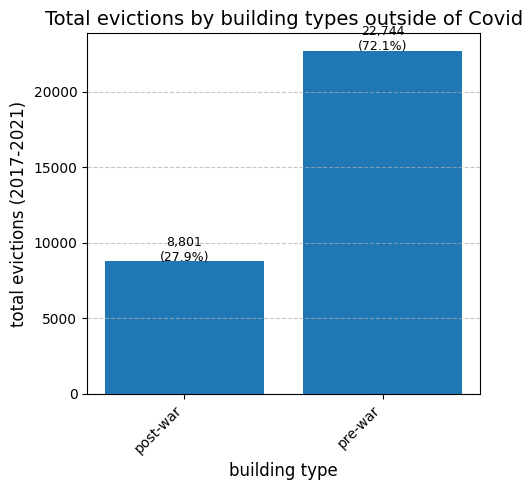

In [170]:
total_all_evictions = category_data['total_evictions'].sum()
# category_data['percentage'] = (category_data['total_evictions'] / total_all_evictions) * 100

plt.figure(figsize=(5, 5))
bars = plt.bar(category_data['building_type'], category_data['total_evictions'])
for i, (value, percentage) in enumerate(zip(category_data['total_evictions'],
                                           category_data['eviction_percentage']*100)):
    plt.text(i, value + (value * 0.0005),
             f"{value:,.0f}\n({percentage:.1f}%)",
             ha='center', fontsize=9)
plt.xlabel('building type', fontsize=12)
plt.ylabel('total evictions (2017-2021)', fontsize=12)
plt.title('Total evictions by building types outside of Covid', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

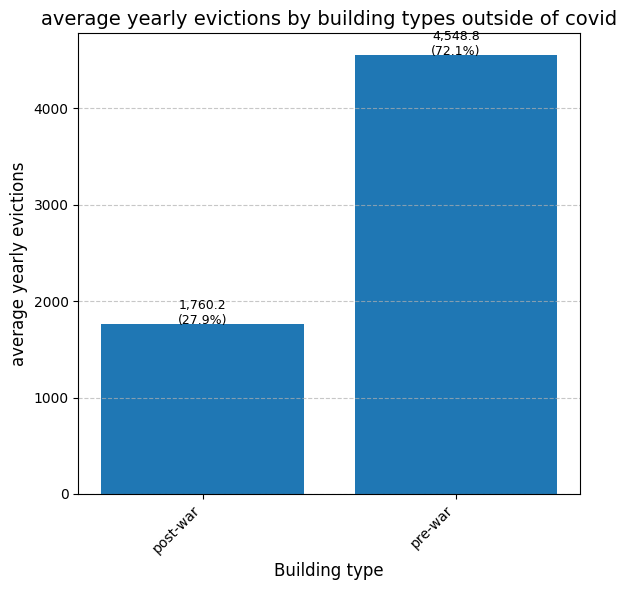

In [165]:
category_data['yearly_evictions'] = category_data['total_evictions'] / 5
total_yearly_evictions = category_data['yearly_evictions'].sum()
category_data['percentage'] = (category_data['yearly_evictions_per_cat'] / total_yearly_evictions) * 100

plt.figure(figsize=(6, 6))
bars = plt.bar(category_data['building_type'], category_data['yearly_evictions_per_cat'])
for i, (value, percentage) in enumerate(zip(category_data['yearly_evictions_per_cat'],
                                            category_data['percentage'])):
    plt.text(i, value + (value * 0.00005),
             f"{value:,.1f}\n({percentage:.1f}%)",
             ha='center', fontsize=9)
plt.xlabel('Building type', fontsize=12)
plt.ylabel('average yearly evictions', fontsize=12)
plt.title('average yearly evictions by building types outside of covid', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

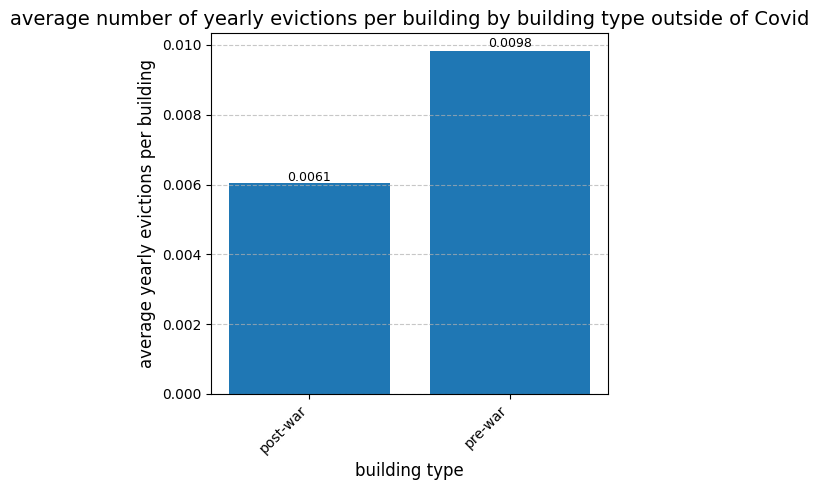

In [166]:
plt.figure(figsize=(5, 5))
bars = plt.bar(category_data['building_type'], category_data['yearly_evictions_per_building_per_cat'])
for i, value in enumerate(category_data['yearly_evictions_per_building_per_cat']):
    plt.text(i, value + (value * 0.01),
             f"{value:.4f}",
             ha='center', fontsize=9)

plt.xlabel('building type', fontsize=12)
plt.ylabel('average yearly evictions per building', fontsize=12)
plt.title('average number of yearly evictions per building by building type outside of Covid', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

In [167]:
print("ranked list of yearly evictions per building:")
sorted_data = category_data.sort_values('yearly_evictions_per_building_per_cat', ascending=False)
for i in range(len(sorted_data)):
    category = sorted_data.iloc[i]['building_type']
    rate = sorted_data.iloc[i]['yearly_evictions_per_building_per_cat']
    print(f"{i+1}. {category}: {rate:.4f}")

ranked list of yearly evictions per building:
1. pre-war: 0.0098
2. post-war: 0.0061


- Disproportionate eviction proportions:

Pre-war buildings represent 61.4% of all buildings but account for 72.1% of all evictions. \
Post-war buildings represent 38.6% of all buildings but account for only 27.9% of all evictions.


- absolute numbers:

For every 1,000 pre-war buildings, roughly 9.8 evictions occur annually. \
For every 1,000 post-war buildings, roughly 6.1 evictions occur annually.

## 3. Architectural Style

In [241]:
category_data = build_category_dataframes(bbl_cleaned, building_evictions_clean, 'architectural_style')
category_data

,architectural_style,total_evictions,eviction_percentage,building_count,building_percentage,evictions_per_building,yearly_evictions_per_cat,yearly_evictions_per_building_per_cat
0,"1900–1920, Beaux-Arts",9427,0.298843,182991,24.298044,0.051516,1885.4,0.010303
1,"1921–1930, Art Deco Skyscrapers",8052,0.255254,153977,20.445486,0.052294,1610.4,0.010459
2,"1931–1950, Manhattan Modern",5326,0.168838,157454,20.907172,0.033826,1065.2,0.006765
3,"1951–1980, the International Style, Alternativ...",3646,0.115581,122280,16.236672,0.029817,729.2,0.005963
4,"1981–2000, Post-Modernism",1128,0.035758,49603,6.586422,0.022741,225.6,0.004548
5,"2001-present, New Architecture",2916,0.092439,48716,6.468643,0.059857,583.2,0.011971
6,Pre-1900,1050,0.033286,38089,5.057561,0.027567,210.0,0.005513


In [242]:
category_data.architectural_style.unique()

array(['1900–1920, Beaux-Arts', '1921–1930, Art Deco Skyscrapers',
       '1931–1950, Manhattan Modern',
       '1951–1980, the International Style, Alternative Modernism',
       '1981–2000, Post-Modernism', '2001-present, New Architecture',
       'Pre-1900'], dtype=object)

In [243]:
order = ['Pre-1900', '1900–1920, Beaux-Arts', '1921–1930, Art Deco Skyscrapers', '1931–1950, Manhattan Modern',
         '1951–1980, the International Style, Alternative Modernism', '1981–2000, Post-Modernism', '2001-present, New Architecture']
category_data['architectural_style'] = pd.Categorical(category_data['architectural_style'], categories= order, ordered=True)
category_data = category_data.sort_values('architectural_style')

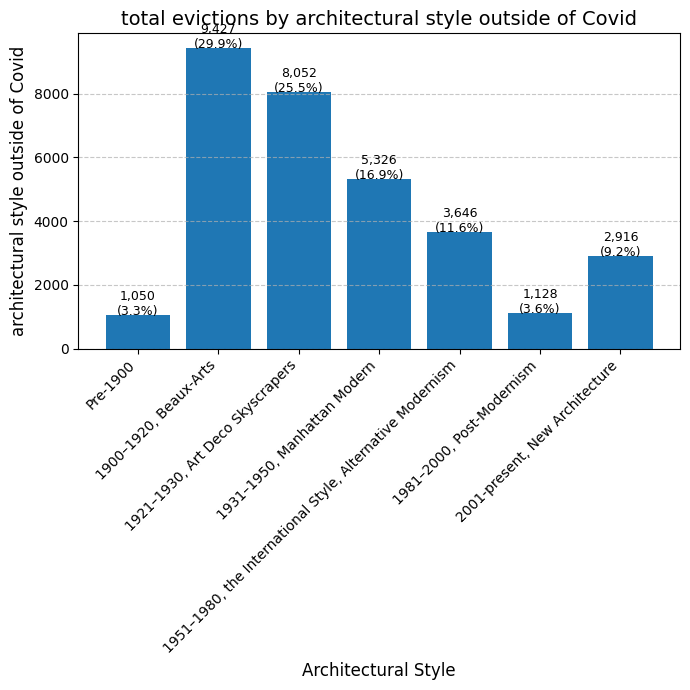

In [244]:
total_all_evictions = category_data['total_evictions'].sum()
# category_data['percentage'] = (category_data['total_evictions'] / total_all_evictions) * 100

plt.figure(figsize=(7, 7))
bars = plt.bar(category_data['architectural_style'], category_data['total_evictions'])
for i, (value, percentage) in enumerate(zip(category_data['total_evictions'],
                                           category_data['eviction_percentage']*100)):
    plt.text(i, value + (value * 0.0001),
             f"{value:,.0f}\n({percentage:.1f}%)",
             ha='center', fontsize=9)
plt.xlabel('Architectural Style', fontsize=12)
plt.ylabel('architectural style outside of Covid', fontsize=12)
plt.title('total evictions by architectural style outside of Covid', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

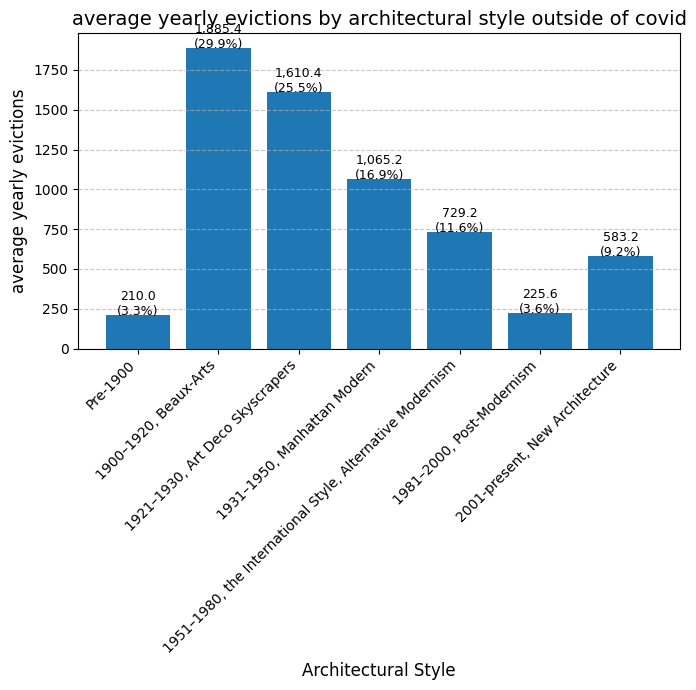

In [245]:
category_data['yearly_evictions'] = category_data['total_evictions'] / 5
total_yearly_evictions = category_data['yearly_evictions'].sum()
category_data['percentage'] = (category_data['yearly_evictions_per_cat'] / total_yearly_evictions) * 100

plt.figure(figsize=(7, 7))
bars = plt.bar(category_data['architectural_style'], category_data['yearly_evictions_per_cat'])
for i, (value, percentage) in enumerate(zip(category_data['yearly_evictions_per_cat'],
                                            category_data['percentage'])):
    plt.text(i, value + (value * 0.00005),
             f"{value:,.1f}\n({percentage:.1f}%)",
             ha='center', fontsize=9)
plt.xlabel('Architectural Style', fontsize=12)
plt.ylabel('average yearly evictions', fontsize=12)
plt.title('average yearly evictions by architectural style outside of covid', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

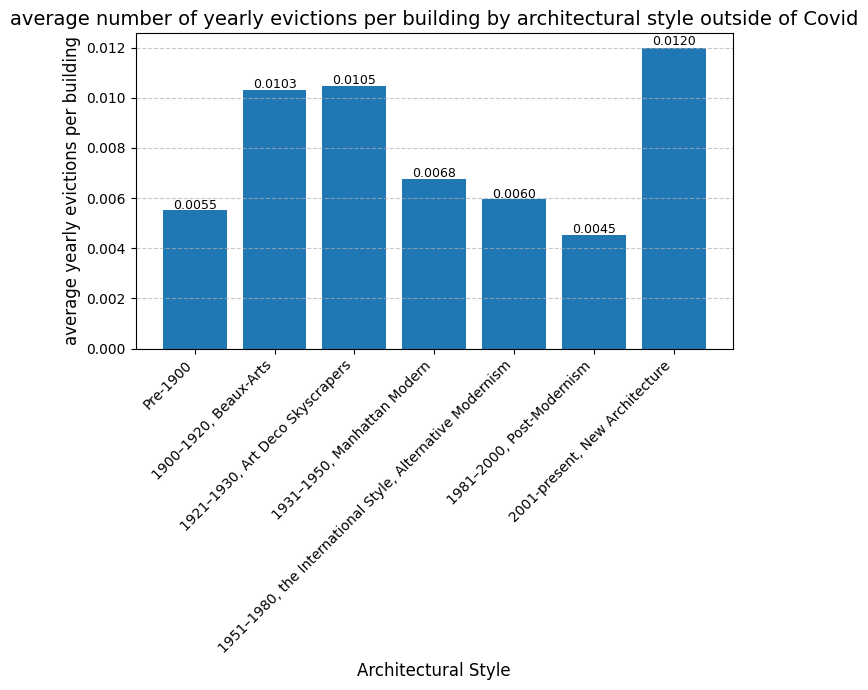

In [246]:
plt.figure(figsize=(7, 7))
bars = plt.bar(category_data['architectural_style'], category_data['yearly_evictions_per_building_per_cat'])
for i, value in enumerate(category_data['yearly_evictions_per_building_per_cat']):
    plt.text(i, value + (value * 0.01),
             f"{value:.4f}",
             ha='center', fontsize=9)

plt.xlabel('Architectural Style', fontsize=12)
plt.ylabel('average yearly evictions per building', fontsize=12)
plt.title('average number of yearly evictions per building by architectural style outside of Covid', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

In [247]:
print("ranked list of yearly evictions per building:")
sorted_data = category_data.sort_values('yearly_evictions_per_building_per_cat', ascending=False)
for i in range(len(sorted_data)):
    category = sorted_data.iloc[i]['architectural_style']
    rate = sorted_data.iloc[i]['yearly_evictions_per_building_per_cat']
    print(f"{i+1}. {category}: {rate:.4f}")

ranked list of yearly evictions per building:
1. 2001-present, New Architecture: 0.0120
2. 1921–1930, Art Deco Skyscrapers: 0.0105
3. 1900–1920, Beaux-Arts: 0.0103
4. 1931–1950, Manhattan Modern: 0.0068
5. 1951–1980, the International Style, Alternative Modernism: 0.0060
6. Pre-1900: 0.0055
7. 1981–2000, Post-Modernism: 0.0045


- non-Linear historical pattern: unlike building size (which showed a clear trend, see below), architectural style shows a non-linear pattern of evictions over time: \

Based on the per building per year analysis:
- high rates in early 20th century (Beaux-Arts, Art Deco)
- declining rates mid-century (Manhattan Modern, International Style)
- lowest rates in late 20th century (Post-Modernism)
- highest rates in 21st century (New Architecture)
- newest buildings have the highest eviction rates: the 2001-present buildings have the highest eviction rate (0.011971), which is 2.17 times higher than the rate for post-modernist buildings from the previous era.

In [259]:
building_evictions_clean.columns

Index(['bbl_clean', 'average_year_eviction_count', 'eviction_count',
       'unitsres', 'building_category', 'building_type', 'is_llc', 'yearbuilt',
       'bldgclass', 'numfloors', 'bldgarea', 'is_condo', 'floor_category',
       'rent_era', 'architectural_style', 'economic_period',
       'residential_units_category', 'building_size_category', 'size_quartile',
       'eviction_rate_per_unit', 'building_age'],
      dtype='object')

In [312]:
# building_evictions_clean.building_age.unique()

## 4.Residential Units Category

In [248]:
category_data = build_category_dataframes(bbl_cleaned, building_evictions_clean, 'residential_units_category')
category_data.residential_units_category.unique()

array(['100+ units', '2-unit', '21-100 units', '3-5 units', '6-20 units',
       'single-unit'], dtype=object)

In [249]:
category_data

,residential_units_category,total_evictions,eviction_percentage,building_count,building_percentage,evictions_per_building,yearly_evictions_per_cat,yearly_evictions_per_building_per_cat
0,100+ units,2203,0.069837,3445,0.457436,0.639478,440.6,0.127896
1,2-unit,6823,0.216294,266988,35.451395,0.025555,1364.6,0.005111
2,21-100 units,9123,0.289206,18111,2.404828,0.503727,1824.6,0.100745
3,3-5 units,5246,0.166302,103859,13.790681,0.050511,1049.2,0.010102
4,6-20 units,5983,0.189666,40058,5.319011,0.149358,1196.6,0.029872
5,single-unit,2167,0.068696,320649,42.576649,0.006758,433.4,0.001352


In [213]:
order = ['single-unit', '2-unit', '3-5 units', '6-20 units', '21-100 units', '100+ units']
category_data['residential_units_category'] = pd.Categorical(category_data['residential_units_category'], categories= order, ordered=True)
category_data = category_data.sort_values('residential_units_category')

In [214]:
category_data

,residential_units_category,total_evictions,eviction_percentage,building_count,building_percentage,evictions_per_building,yearly_evictions_per_cat,yearly_evictions_per_building_per_cat
5,single-unit,2167,0.068696,320649,42.576649,0.006758,433.4,0.001352
1,2-unit,6823,0.216294,266988,35.451395,0.025555,1364.6,0.005111
3,3-5 units,5246,0.166302,103859,13.790681,0.050511,1049.2,0.010102
4,6-20 units,5983,0.189666,40058,5.319011,0.149358,1196.6,0.029872
2,21-100 units,9123,0.289206,18111,2.404828,0.503727,1824.6,0.100745
0,100+ units,2203,0.069837,3445,0.457436,0.639478,440.6,0.127896


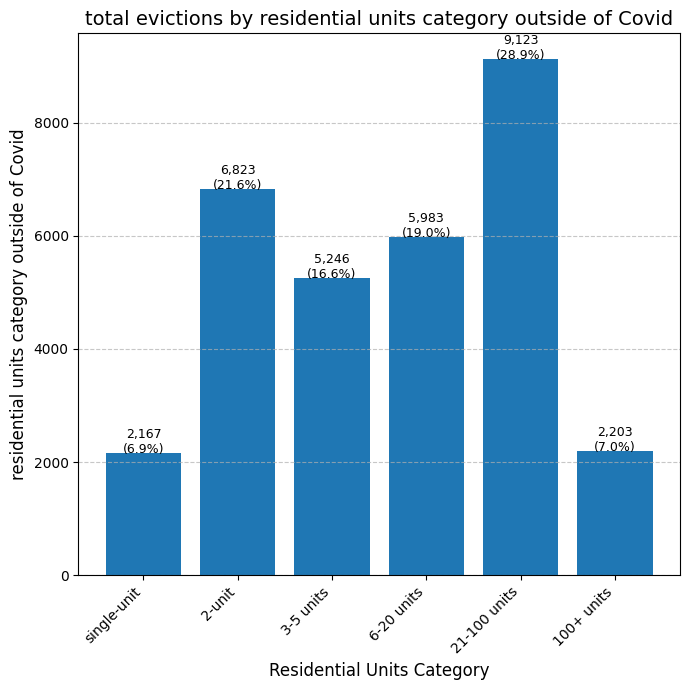

In [216]:
total_all_evictions = category_data['total_evictions'].sum()
# category_data['percentage'] = (category_data['total_evictions'] / total_all_evictions) * 100

plt.figure(figsize=(7, 7))
bars = plt.bar(category_data['residential_units_category'], category_data['total_evictions'])
for i, (value, percentage) in enumerate(zip(category_data['total_evictions'],
                                           category_data['eviction_percentage']*100)):
    plt.text(i, value + (value * 0.0001),
             f"{value:,.0f}\n({percentage:.1f}%)",
             ha='center', fontsize=9)
plt.xlabel('Residential Units Category', fontsize=12)
plt.ylabel('residential units category outside of Covid', fontsize=12)
plt.title('total evictions by residential units category outside of Covid', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

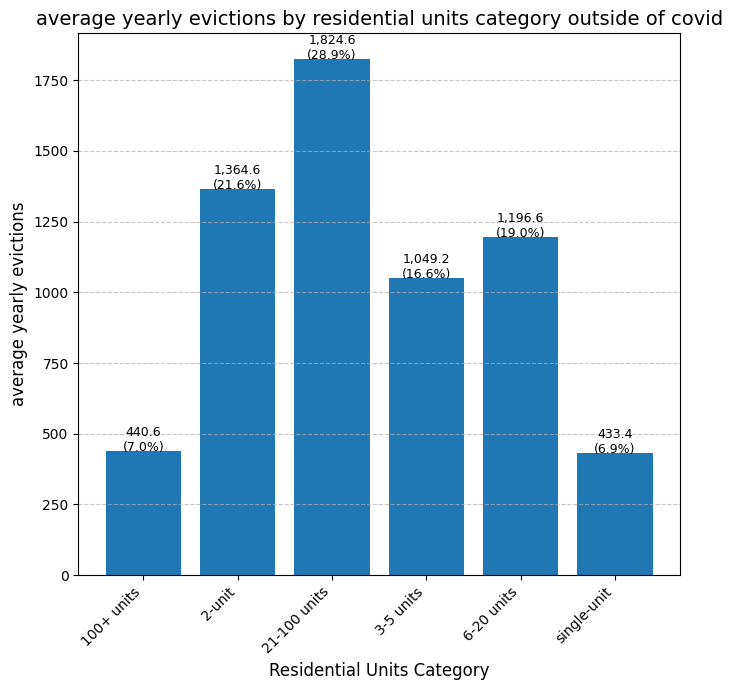

In [250]:
category_data['yearly_evictions'] = category_data['total_evictions'] / 5
total_yearly_evictions = category_data['yearly_evictions'].sum()
category_data['percentage'] = (category_data['yearly_evictions_per_cat'] / total_yearly_evictions) * 100

plt.figure(figsize=(7, 7))
bars = plt.bar(category_data['residential_units_category'], category_data['yearly_evictions_per_cat'])
for i, (value, percentage) in enumerate(zip(category_data['yearly_evictions_per_cat'],
                                            category_data['percentage'])):
    plt.text(i, value + (value * 0.00005),
             f"{value:,.1f}\n({percentage:.1f}%)",
             ha='center', fontsize=9)
plt.xlabel('Residential Units Category', fontsize=12)
plt.ylabel('average yearly evictions', fontsize=12)
plt.title('average yearly evictions by residential units category outside of covid', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

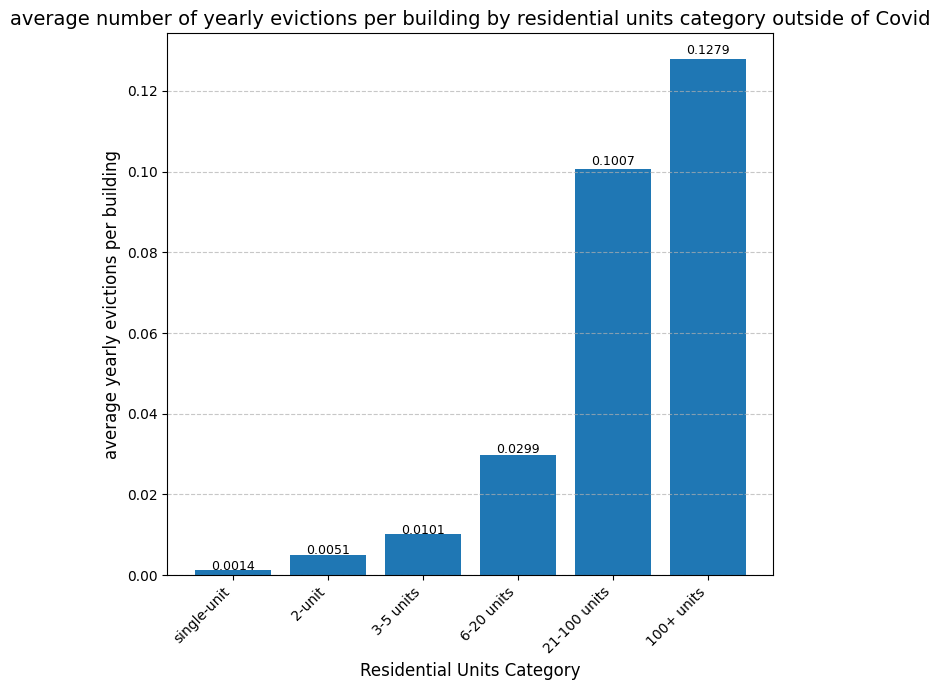

In [220]:
plt.figure(figsize=(7, 7))
bars = plt.bar(category_data['residential_units_category'], category_data['yearly_evictions_per_building_per_cat'])
for i, value in enumerate(category_data['yearly_evictions_per_building_per_cat']):
    plt.text(i, value + (value * 0.01),
             f"{value:.4f}",
             ha='center', fontsize=9)

plt.xlabel('Residential Units Category', fontsize=12)
plt.ylabel('average yearly evictions per building', fontsize=12)
plt.title('average number of yearly evictions per building by residential units category outside of Covid', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

In [221]:
print("ranked list of yearly evictions per building:")
sorted_data = category_data.sort_values('yearly_evictions_per_building_per_cat', ascending=False)
for i in range(len(sorted_data)):
    category = sorted_data.iloc[i]['residential_units_category']
    rate = sorted_data.iloc[i]['yearly_evictions_per_building_per_cat']
    print(f"{i+1}. {category}: {rate:.4f}")

ranked list of yearly evictions per building:
1. 100+ units: 0.1279
2. 21-100 units: 0.1007
3. 6-20 units: 0.0299
4. 3-5 units: 0.0101
5. 2-unit: 0.0051
6. single-unit: 0.0014


Strong building-size correlation with eviction rates: \
There is a 100% consistent relationship between building size and eviction rates. The more units the buildings have, the higher the eviction rate per buiding increases. We also observe some drastic magnitude difference: eviction rate in large buildings (100 + units) is 94.6 times higher than in single-unit buildings. (0.127896 vs. 0.001352 yearly evictions per building.)\

It is also noteworthy that buildings with 21+ units represent only 2.9% of all buildings but account for 35.9% of all evictions. \
Single-unit and 2-unit buildings represent 78.0% of all buildings but account for only 28.5% of evictions

## 5. Building Size Category

In [251]:
category_data = build_category_dataframes(bbl_cleaned, building_evictions_clean, 'building_size_category')
category_data.building_size_category.unique()

array(['large', 'medium', 'medium-small', 'mega', 'small', 'tiny',
       'very large', 'very small'], dtype=object)

In [252]:
category_data

,building_size_category,total_evictions,eviction_percentage,building_count,building_percentage,evictions_per_building,yearly_evictions_per_cat,yearly_evictions_per_building_per_cat
0,large,4461,0.141417,14761,1.960006,0.302215,892.2,0.060443
1,medium,3087,0.097860,31069,4.125427,0.099359,617.4,0.019872
2,medium-small,4561,0.144587,105397,13.994901,0.043274,912.2,0.008655
3,mega,2152,0.068220,3740,0.496607,0.575401,430.4,0.115080
4,small,5306,0.168204,206682,27.443800,0.025672,1061.2,0.005134
5,tiny,315,0.009986,29398,3.903547,0.010715,63.0,0.002143
6,very large,7027,0.222761,13011,1.727636,0.540081,1405.4,0.108016
7,very small,4636,0.146965,349052,46.348077,0.013282,927.2,0.002656


In [253]:
order = ['tiny', 'very small', 'small','medium-small', 'medium','large', 'very large','mega']
category_data['building_size_category'] = pd.Categorical(category_data['building_size_category'], categories= order, ordered=True)
category_data = category_data.sort_values('building_size_category')

In [254]:
category_data

,building_size_category,total_evictions,eviction_percentage,building_count,building_percentage,evictions_per_building,yearly_evictions_per_cat,yearly_evictions_per_building_per_cat
5,tiny,315,0.009986,29398,3.903547,0.010715,63.0,0.002143
7,very small,4636,0.146965,349052,46.348077,0.013282,927.2,0.002656
4,small,5306,0.168204,206682,27.443800,0.025672,1061.2,0.005134
2,medium-small,4561,0.144587,105397,13.994901,0.043274,912.2,0.008655
1,medium,3087,0.097860,31069,4.125427,0.099359,617.4,0.019872
0,large,4461,0.141417,14761,1.960006,0.302215,892.2,0.060443
6,very large,7027,0.222761,13011,1.727636,0.540081,1405.4,0.108016
3,mega,2152,0.068220,3740,0.496607,0.575401,430.4,0.115080


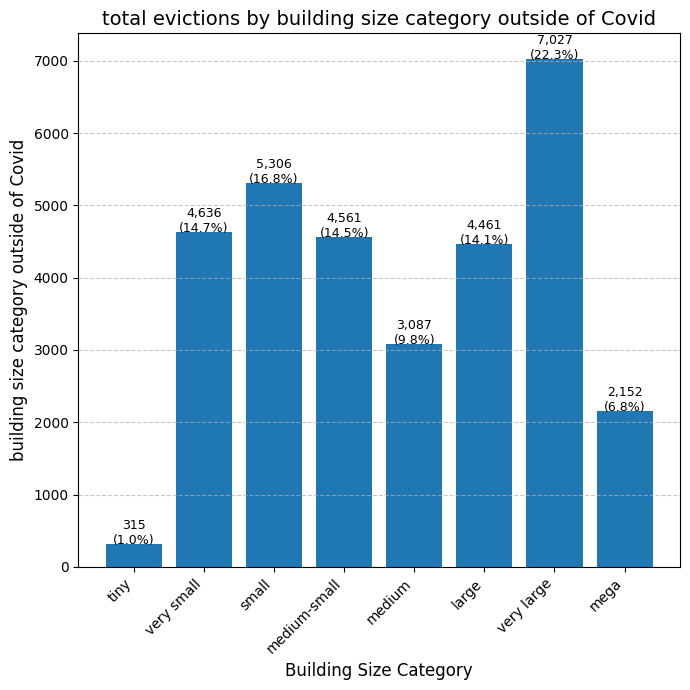

In [255]:
total_all_evictions = category_data['total_evictions'].sum()
# category_data['percentage'] = (category_data['total_evictions'] / total_all_evictions) * 100

plt.figure(figsize=(7, 7))
bars = plt.bar(category_data['building_size_category'], category_data['total_evictions'])
for i, (value, percentage) in enumerate(zip(category_data['total_evictions'],
                                           category_data['eviction_percentage']*100)):
    plt.text(i, value + (value * 0.0001),
             f"{value:,.0f}\n({percentage:.1f}%)",
             ha='center', fontsize=9)
plt.xlabel('Building Size Category', fontsize=12)
plt.ylabel('building size category outside of Covid', fontsize=12)
plt.title('total evictions by building size category outside of Covid', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

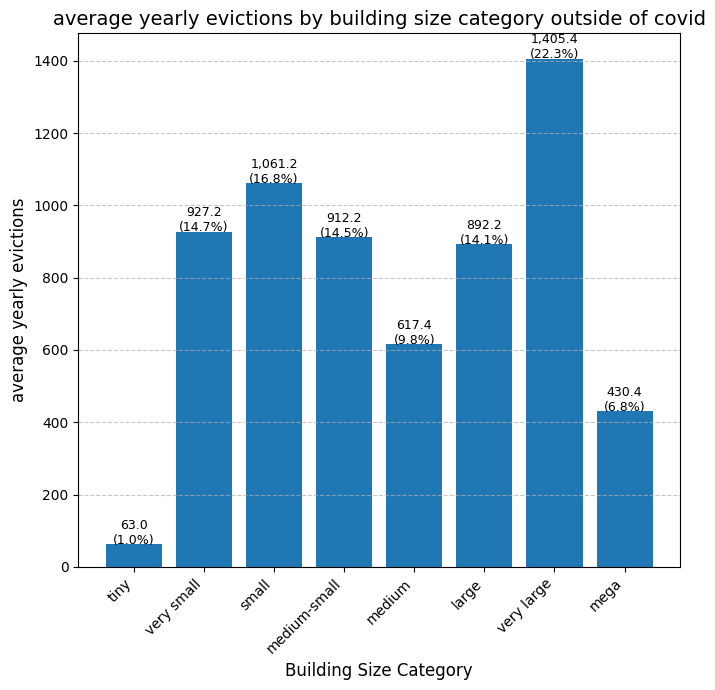

In [256]:
category_data['yearly_evictions'] = category_data['total_evictions'] / 5
total_yearly_evictions = category_data['yearly_evictions'].sum()
category_data['percentage'] = (category_data['yearly_evictions_per_cat'] / total_yearly_evictions) * 100

plt.figure(figsize=(7, 7))
bars = plt.bar(category_data['building_size_category'], category_data['yearly_evictions_per_cat'])
for i, (value, percentage) in enumerate(zip(category_data['yearly_evictions_per_cat'],
                                            category_data['percentage'])):
    plt.text(i, value + (value * 0.0005),
             f"{value:,.1f}\n({percentage:.1f}%)",
             ha='center', fontsize=9)
plt.xlabel('Building Size Category', fontsize=12)
plt.ylabel('average yearly evictions', fontsize=12)
plt.title('average yearly evictions by building size category outside of covid', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

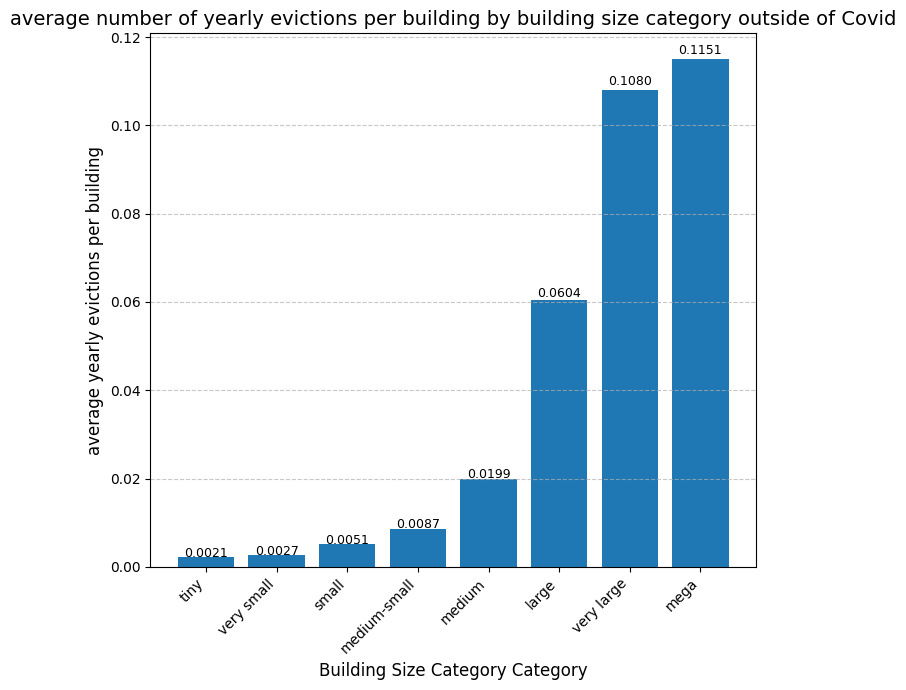

In [257]:
plt.figure(figsize=(7, 7))
bars = plt.bar(category_data['building_size_category'], category_data['yearly_evictions_per_building_per_cat'])
for i, value in enumerate(category_data['yearly_evictions_per_building_per_cat']):
    plt.text(i, value + (value * 0.01),
             f"{value:.4f}",
             ha='center', fontsize=9)

plt.xlabel('Building Size Category Category', fontsize=12)
plt.ylabel('average yearly evictions per building', fontsize=12)
plt.title('average number of yearly evictions per building by building size category outside of Covid', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

In [235]:
print("ranked list of yearly evictions per building:")
sorted_data = category_data.sort_values('yearly_evictions_per_building_per_cat', ascending=False)
for i in range(len(sorted_data)):
    category = sorted_data.iloc[i]['building_size_category']
    rate = sorted_data.iloc[i]['yearly_evictions_per_building_per_cat']
    print(f"{i+1}. {category}: {rate:.4f}")

ranked list of yearly evictions per building:
1. mega: 0.1151
2. very large: 0.1080
3. large: 0.0604
4. medium: 0.0199
5. medium-small: 0.0087
6. small: 0.0051
7. very small: 0.0027
8. tiny: 0.0021


The trend is as clear as when we use the unit_size - mega buildings have an eviction rate approximately 54 times higher than tiny buildings. This strong correlation between building size and eviction rate suggests that building size (and associated higher unit numbers, management practices, ownership structures, and tenant compositions) combing with other factors (locations) could indicate primary determinant of eviction risk.